In [1]:
!pip install -q ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl
!pip install -q ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q ../input/for-pydicom/pylibjpeg_libjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q -U keras-tuner

# Note : #

### In this notebook we are going to use Keras tuner to tune hyperparamteres, like Learning Rate to see improvement in the training process ###

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from glob import glob
import pydicom
import tensorflow as tf
import tqdm as tqdm
import tensorflow_io as tfio
import pathlib
import datetime
from tensorflow import keras
import keras_tuner as kt

In [3]:
DATA_DIR = "../input/rsna-2022-cervical-spine-fracture-detection/"
trainCsv = "../input/rsna-2022-cervical-spine-fracture-detection/train.csv"
train_df = pd.read_csv(trainCsv)
print(train_df.head())

            StudyInstanceUID  patient_overall  C1  C2  C3  C4  C5  C6  C7
0   1.2.826.0.1.3680043.6200                1   1   1   0   0   0   0   0
1  1.2.826.0.1.3680043.27262                1   0   1   0   0   0   0   0
2  1.2.826.0.1.3680043.21561                1   0   1   0   0   0   0   0
3  1.2.826.0.1.3680043.12351                0   0   0   0   0   0   0   0
4   1.2.826.0.1.3680043.1363                1   0   0   0   0   1   0   0


In [4]:
def load_dicom(path):
    """
    reads a dicom file and loads the image array inside it
    inputs:
        path: the path of the required dicom file
    returns:
        data: image pixel arrays
    """
    img=pydicom.dcmread(path)
    data=img.pixel_array
    data=data-np.min(data)
    if np.max(data) != 0:
        data=data/np.max(data)
    data=(data*255).astype(np.uint8)
    return data

In [5]:
def data_generator():
    for i, study_instance in enumerate(train_df.StudyInstanceUID[:]):
        for dcm in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            train_labels = []
            path = DATA_DIR + f"train_images/{study_instance}/{dcm}"
            img = load_dicom(path)
            
            # resize each image into a shape of (512, 512)
            img = np.resize(img, (128, 128))
            #  normalize image
            img = img / 255.0
            # convert from gray scale to rgb, this will be helpful incase we want to use pretrained models
            img = tf.expand_dims(img, axis=-1)
            img = tf.image.grayscale_to_rgb(img)
            
            train_labels.extend([
                train_df.loc[i, "C1"],
                train_df.loc[i, "C2"],
                train_df.loc[i, "C3"],
                train_df.loc[i, "C4"],
                train_df.loc[i, "C5"],
                train_df.loc[i, "C6"],
                train_df.loc[i, "C7"],
                train_df.loc[i, "patient_overall"] # end with patient overall
            ])
            yield img, train_labels

In [6]:
# creating train, validation and test split for evaluation
def splitDataset(dataset, trainFactor, img_count): # here it refers to tf.dataset
    train_dataset = dataset.take(int(trainFactor * img_count))
    
    valid_test_split = (1 - trainFactor) / 2
    validation_dataset = dataset.take(int(valid_test_split* img_count))
    test_dataset = dataset.take(int(valid_test_split* img_count))
    return train_dataset, validation_dataset, test_dataset

In [7]:
def configure_for_performance(data):
    data = data.cache()
    data = data.batch(16)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data

In [8]:
def creating_model(hp):
    IMG_SHAPE = (128, 128, 3)
    base_model = tf.keras.applications.EfficientNetB5(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
    
    base_model.trainable = False
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(8, activation = 'sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
    
    return model

In [9]:
# this is required because of length of dataset is not valid for generators
def getImageCount():
    img_count = 0
    for _, study_instance in enumerate(train_df.StudyInstanceUID[:5]):
        for _ in os.listdir(DATA_DIR + f"train_images/{study_instance}"):
            img_count += 1
            
    return img_count

In [10]:
def createTensorboardCallback(logdir):
    return tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

def saveModelCallback(filePath):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filePath, monitor='val_loss',verbose=1, save_best_only=True, mode='min')
    
    return checkpoint

In [11]:
def display(history):
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
# getting the dataset
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# creating the dataset
dataset = tf.data.Dataset.from_generator(data_generator, (tf.float32, tf.int8))

# printing a sample data for checking
for img, label in dataset.take(1):
    print(img.shape)
    print(label.shape)
    print(label)

# splitting the dataset
trainFactor = 0.8
img_count = getImageCount()
print("[***] Images for training and validation : ", img_count)
train_data, validation_data, test_dataset = splitDataset(dataset, trainFactor, img_count)
#
train_dataset = configure_for_performance(train_data)
validation_dataset = configure_for_performance(validation_data)

# printing dataset structure after batching
print("[*] Dataset after batching")
for img, label in train_dataset.take(1):
    print(img.shape)
    print(label.shape)

2022-09-05 22:01:12.866689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 22:01:13.028357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 22:01:13.029305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 22:01:13.032833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(128, 128, 3)
(8,)
tf.Tensor([1 1 0 0 0 0 0 1], shape=(8,), dtype=int8)
[***] Images for training and validation :  1734
[*] Dataset after batching
(16, 128, 128, 3)
(16, 8)


2022-09-05 22:01:16.980511: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Using Keras tuner to tune the learning rate and see improvements ##

In [13]:
mydir = "/kaggle/working/my_dir"
os.makedirs(mydir, exist_ok=True)

tuner = kt.Hyperband(creating_model,
                     objective='val_binary_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory=mydir,
                     project_name='rsna_baseline_improve_1')

# creating a stop early callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_dataset, epochs=10, validation_data = validation_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}""")

print("[*] Results Summary")
print(tuner.results_summary())

Trial 3 Complete [00h 00m 32s]
val_binary_accuracy: 0.875

Best val_binary_accuracy So Far: 0.875
Total elapsed time: 00h 02m 09s

The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.0001
[*] Results Summary
Results summary
Results in /kaggle/working/my_dir/rsna_baseline_improve_1
Showing 10 best trials
Trial summary
Hyperparameters:
learning_rate: 0.0001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.875
Trial summary
Hyperparameters:
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.875
Trial summary
Hyperparameters:
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.625
None


## Now training the model with the obtained tuned hyperparameters ##

In [14]:
# creating the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)
print(model.summary)
print(model.optimizer.get_config())

# training
EPOCHS = 10
BATCH_SIZE = 4
# tensorboard logging dir
foldername = "/kaggle/working/tensorboardRecord"
os.makedirs(foldername, exist_ok=True)
logdir = os.path.join(foldername, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


# modelsave checkpoint
modelDir = "/kaggle/working/modelDir"
os.makedirs(modelDir, exist_ok=True)
#filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
filepath = 'best_model.hdf5'
modelSavePath = os.path.join(modelDir, filepath)

tensorboardCallback = createTensorboardCallback(logdir)
modeSaveCallback = saveModelCallback(modelSavePath)
history = model.fit(train_dataset, epochs = EPOCHS, validation_data = validation_dataset, callbacks=[modeSaveCallback])


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7f0d2b781990>>
{'name': 'Adam', 'learning_rate': 0.0001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


2022-09-05 22:07:13.563684: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-05 22:07:13.563728: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-05 22:07:13.564616: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-09-05 22:07:13.908328: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-05 22:07:13.908571: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/10
87/87 [==============================] - 21s 81ms/step - loss: 0.3853 - binary_accuracy: 0.8195 - val_loss: 0.4057 - val_binary_accuracy: 0.8750

Epoch 00001: val_loss improved from inf to 0.40573, saving model to /kaggle/working/modelDir/best_model.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
87/87 [==============================] - 4s 47ms/step - loss: 0.2552 - binary_accuracy: 0.9059 - val_loss: 0.4246 - val_binary_accuracy: 0.8750

Epoch 00002: val_loss did not improve from 0.40573
Epoch 3/10
87/87 [==============================] - 4s 45ms/step - loss: 0.2530 - binary_accuracy: 0.9059 - val_loss: 0.4245 - val_binary_accuracy: 0.8750

Epoch 00003: val_loss did not improve from 0.40573
Epoch 4/10
87/87 [==============================] - 4s 46ms/step - loss: 0.2528 - binary_accuracy: 0.9038 - val_loss: 0.4240 - val_binary_accuracy: 0.8750

Epoch 00004: val_loss did not improve from 0.40573
Epoch 5/10
87/87 [==============================] - 4s 45ms/step - loss: 0.2485 - binary_accuracy: 0.9055 - val_loss: 0.4225 - val_binary_accuracy: 0.8750

Epoch 00005: val_loss did not improve from 0.40573
Epoch 6/10
87/87 [==============================] - 4s 49ms/step - loss: 0.2476 - binary_accuracy: 0.9050 - val_loss: 0.4272 - val_binary_accuracy: 0.8750

Epoch 00006: val

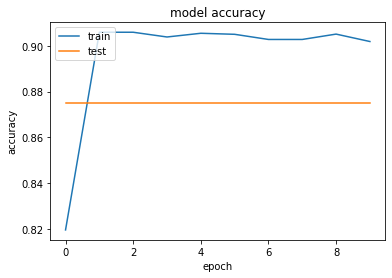

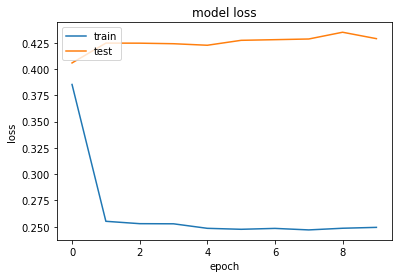

In [15]:
import matplotlib.pyplot as plt
display(history)